# Wasserstein GAN with Gradient Penalty (WGAN-GP)

### Goals
In this notebook, you're going to build a Wasserstein GAN with Gradient Penalty (WGAN-GP) that solves some of the stability issues with the GANs that you have been using up until this point. Specifically, you'll use a special kind of loss function known as the W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.

*Fun Fact: Wasserstein is named after a mathematician at Penn State, Leonid Vaseršteĭn. You'll see it abbreviated to W (e.g. WGAN, W-loss, W-distance).*

### Learning Objectives
1.   Get hands-on experience building a more stable GAN: Wasserstein GAN with Gradient Penalty (WGAN-GP).
2.   Train the more advanced WGAN-GP model.



## Generator and Critic

You will begin by importing some useful packages, defining visualization functions, building the generator, and building the critic. Since the changes for WGAN-GP are done to the loss function during training, you can simply reuse your previous GAN code for the generator and critic class. Remember that in WGAN-GP, you no longer use a discriminator that classifies fake and real as 0 and 1 but rather a critic that scores images with real numbers.

#### Packages and Visualizations

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Critic

In [3]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations
Now you can start putting it all together.
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section
  *   device: the device type

You will also load and transform the MNIST dataset to tensors.




In [4]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, critic, and optimizers.

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


## Gradient Penalty
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

You can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once you have the intermediate image, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input). You will need to fill in the code to get the gradient wherever you see *None*. There is a test function in the next block for you to test your solution.

In [6]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [7]:
# UNIT TEST
# DO NOT MODIFY THIS
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Success!")

Success!


The second function you need to complete is to compute the gradient penalty given the gradient. First, you calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

Again, you will need to fill in the code wherever you see *None*. There are hints below that you can view if you need help and there is a test function in the next block for you to test your solution.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">gradient_penalty</font></code></b>
</font>
</summary>


1.   Make sure you take the mean at the end.
2.   Note that the magnitude of each gradient has already been calculated for you.

</details>


In [8]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: gradient_penalty
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm-1)**2)
    #### END CODE HERE ####
    return penalty

In [9]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Success!")

Success!


## Losses
Next, you need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but you will use the mean of them.

There are optional hints below and a test function in the next block for you to test your solution.

<details><summary><font size="3" color="green"><b>Optional hints for <code><font size="4">get_gen_loss</font></code></b></font></summary>

1. This can be written in one line.
2. This is the negative of the mean of the critic's scores.

</details>

In [10]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -1. * torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [11]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_loss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Success!")

Success!


For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and you will use the mean of them.

There are hints below if you get stuck and a test function in the next block for you to test your solution.

<details><summary><font size="3" color="green"><b>Optional hints for <code><font size="4">get_crit_loss</font></code></b></font></summary>

1. The higher the mean fake score, the higher the critic's loss is.
2. What does this suggest about the mean real score?
3. The higher the gradient penalty, the higher the critic's loss is, proportional to lambda.


</details>


In [12]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_crit_loss
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss

In [13]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


## Putting It All Together
Before you put everything together, there are a few things to note.
1.   Even on GPU, the **training will run more slowly** than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2.   One important difference from earlier versions is that you will **update the critic multiple times** every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using). 
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.


<!-- Once again, be warned that this runs very slowly on a CPU. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab and make the runtime type GPU and replace
`device = "cpu"`
with
`device = "cuda"`
and make sure that your `get_noise` function uses the right device.  -->

Here is a snapshot of what your WGAN-GP outputs should resemble:
![MNIST Digits Progression](MNIST_WGAN_Progression.png)

Epoch 1, step 500: Generator loss: 5.822781631593127, critic loss: -106.78105248900057


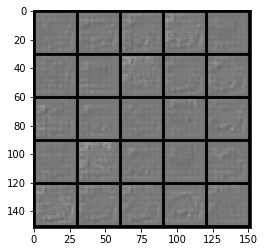

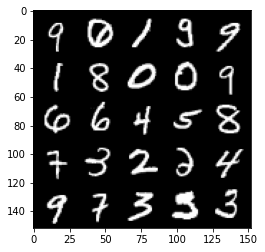

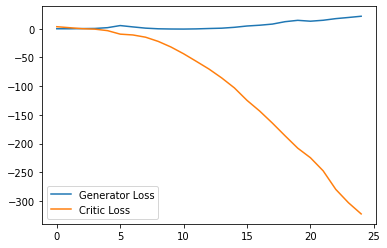

Epoch 2, step 1000: Generator loss: 7.290005300045014, critic loss: -339.76593874206543


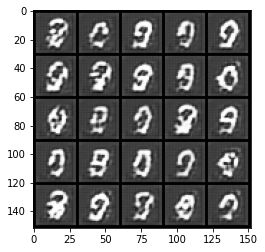

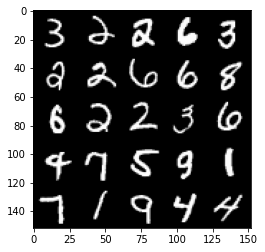

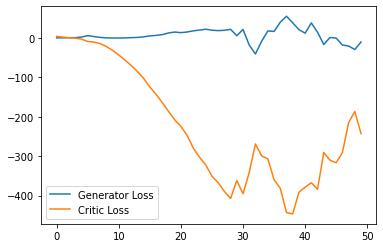

Epoch 3, step 1500: Generator loss: 6.995925795555115, critic loss: 32.93617394866941


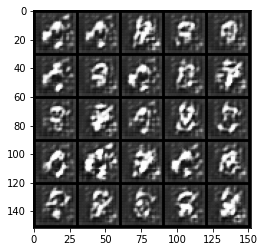

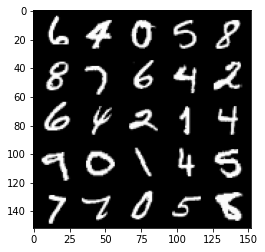

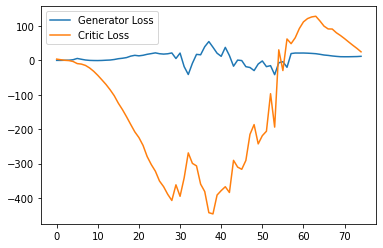

Epoch 4, step 2000: Generator loss: 22.595048414230348, critic loss: 5.172859564113611


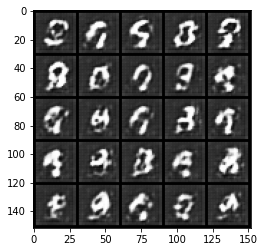

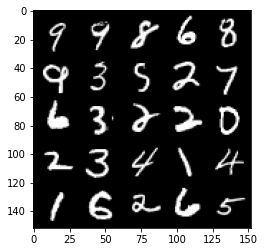

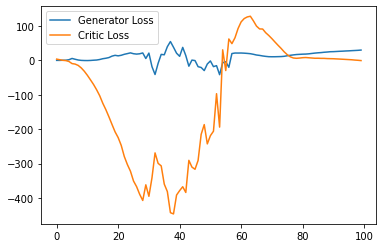

Epoch 5, step 2500: Generator loss: 32.378635356903075, critic loss: -10.937687070178988


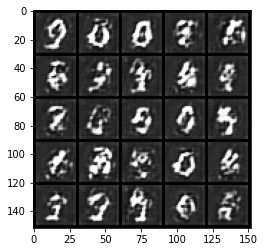

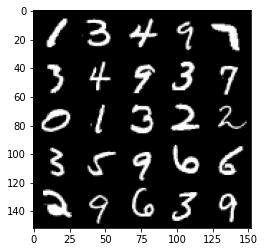

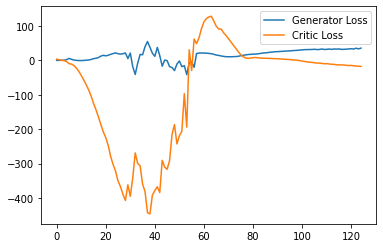

Epoch 6, step 3000: Generator loss: 38.27393302536011, critic loss: -18.856707527732837


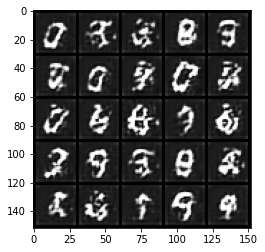

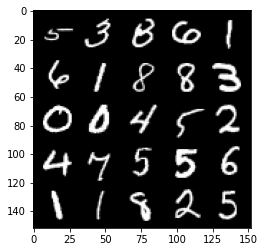

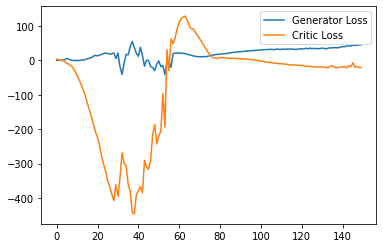

Epoch 7, step 3500: Generator loss: 47.70634474563599, critic loss: -5.895403163385393


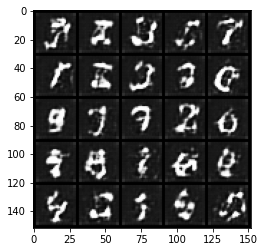

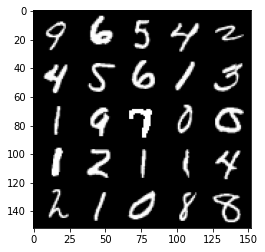

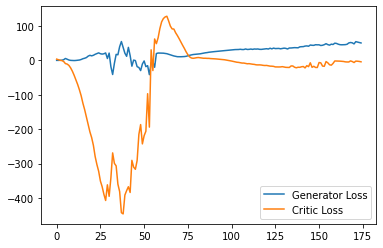

Epoch 8, step 4000: Generator loss: 53.515844749450686, critic loss: -4.630316225099565


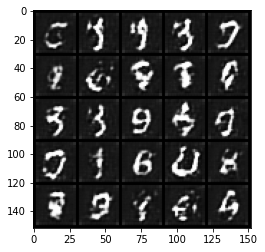

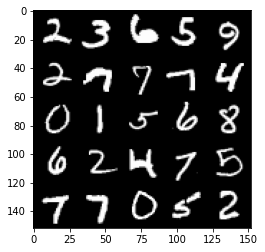

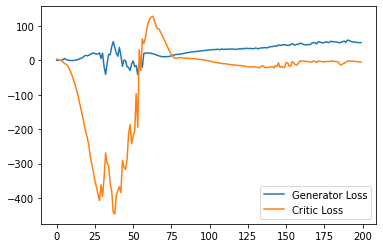

Epoch 9, step 4500: Generator loss: 54.69860066223144, critic loss: -7.681501130890848


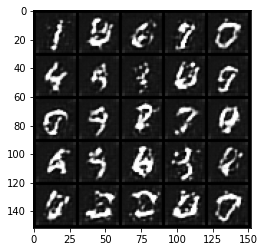

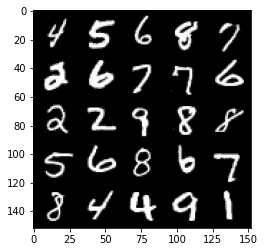

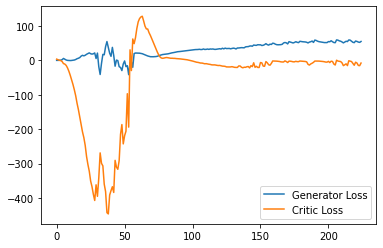

Epoch 10, step 5000: Generator loss: 54.55741512298584, critic loss: -8.478133872032162


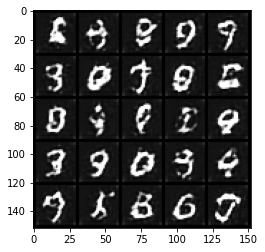

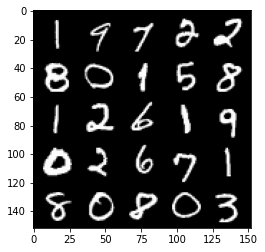

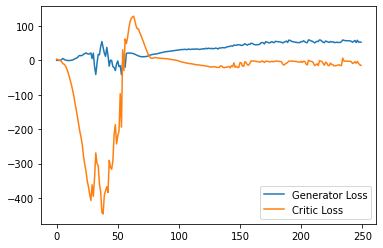

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


In [ ]:
!pip freeze